C:\Users\lky60\AppData\Local\Temp\ipykernel_25784\286185107.py:46: RuntimeWarning: invalid value encountered in sqrt
  return np.logical_and(((y-cy)/chord)**2 - 0.36*(-0.1015 * ((x-cx)/chord) ** 4 + 0.2843 * ((x-cx)/chord) ** 3 - 0.3576 * ((x-cx)/chord) ** 2 - 0.1221 * ((x-cx)/chord) + 0.2969 * ((x-cx)/chord)**0.5)**2 < 0, np.logical_and(x > cx, x - cx < chord))


36.86444444444623
106.41666666666669
1.7272262288848723
109.5655107944645
0.2844964296989909
115.7816666065041
2.1274569233259513
108.4199795252896
0.567183449458396
114.34862947252286
1.5770714819486769
110.3698799786613
0.9739705815834897
112.38397776612956
1.1298714097508655
111.91500721024146
1.2316245574545037
111.29155256622202
0.9520892393859371
112.51971627920774
1.2909052818877802
111.12663093860682
0.981227190338433
112.39270878696121
1.2290610231352477
111.47985473467037


KeyboardInterrupt: 

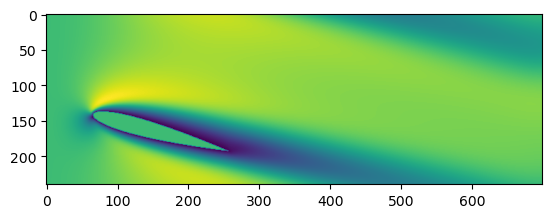

In [28]:
# 2D flow around a NACA0012 airfoil
from numpy import *
from numpy.linalg import *
import matplotlib.pyplot as plt
from matplotlib import cm
from math import cos,sin,pi
###### Flow definition #########################################################
maxIter = 200000 # Total number of time iterations.
Re      = 220.0  # Reynolds number.
nx = 700; ny = 240; ly=ny-1.0; q = 9 # Lattice dimensions and populations.
cx = nx/7; cy=ny/2; r=ny/9;          # Coordinates of the cylinder.
chord = nx/3.5
uLB     = 0.04                       # Velocity in lattice units.
nulb    = uLB*chord/Re; omega = 1.0 / (3.*nulb+0.5); # Relaxation parameter.
attack_angle = 15
 
###### Lattice Constants #######################################################
c = array([(x,y) for x in [0,-1,1] for y in [0,-1,1]]) # Lattice velocities.
t = 1./36. * ones(q)                                   # Lattice weights.
t[asarray([norm(ci)<1.1 for ci in c])] = 1./9.; t[0] = 4./9.
noslip = [c.tolist().index((-c[i]).tolist()) for i in range(q)] 
i1 = arange(q)[asarray([ci[0]<0  for ci in c])] # Unknown on right wall.
i2 = arange(q)[asarray([ci[0]==0 for ci in c])] # Vertical middle.
i3 = arange(q)[asarray([ci[0]>0  for ci in c])] # Unknown on left wall.
 
###### Function Definitions ####################################################
sumpop = lambda fin: sum(fin,axis=0) # Helper function for density computation.
def equilibrium(rho,u):              # Equilibrium distribution function.
    cu   = 3.0 * dot(c,u.transpose(1,0,2))
    usqr = 3./2.*(u[0]**2+u[1]**2)
    feq = zeros((q,nx,ny))
    for i in range(q): feq[i,:,:] = rho*t[i]*(1.+cu[i]+0.5*cu[i]**2-usqr)
    return feq

def airfoil_shape(x,y):
    if ((y-cy)/chord)**2-0.36*(-0.1015 * ((x-cx)/chord) ** 4 + 0.2843 * ((x-cx)/chord) ** 3 - 0.3576 * ((x-cx)/chord) ** 2 - 0.1221 * ((x-cx)/chord) + 0.2969 * ((x-cx)/chord)**0.5)**2>=0:
        return False
    elif x<=cx or x-cx>=chord:
        return False
    else:
        return True
    
def generate_airfoil(x_,y_):
    x = x_*cos(-attack_angle/180*pi)-y_*sin(-attack_angle/180*pi)
    y = x_*sin(-attack_angle/180*pi)+y_*cos(-attack_angle/180*pi)
    return np.logical_and(((y-cy)/chord)**2 - 0.36*(-0.1015 * ((x-cx)/chord) ** 4 + 0.2843 * ((x-cx)/chord) ** 3 - 0.3576 * ((x-cx)/chord) ** 2 - 0.1221 * ((x-cx)/chord) + 0.2969 * ((x-cx)/chord)**0.5)**2 < 0, np.logical_and(x > cx, x - cx < chord))

    
# obstacle = fromfunction(generate_airfoil, (nx,ny))
    
 
###### Setup: cylindrical obstacle and velocity inlet with perturbation ########
# obstacle = fromfunction(lambda x,y: (x-cx)**2+(y-cy)**2<r**2, (nx,ny))
# obstacle = fromfunction(lambda x,y: ((y-cy)/ny)**2-0.36*(0.1015 * ((x-cx)/nx) ** 4 + 0.2843 * ((x-cx)/nx) ** 3 - 0.3576 * ((x-cx)/nx) ** 2 - 0.1221 * ((x-cx)/nx) + 0.2969 * ((x-cx)/nx)**0.5)**2<0, (nx,ny))
# obstacle = fromfunction(lambda x,y: ((((y-cy)/ny)**2-0.36*(-0.1015 * ((x-cx)/chord) ** 4 + 0.2843 * ((x-cx)/chord) ** 3 - 0.3576 * ((x-cx)/chord) ** 2 - 0.1221 * ((x-cx)/chord) + 0.2969 * ((x-cx)/chord)**0.5)**2<0) and (x>cx) and (x-cx<chord)), (nx,ny))
# print(obstacle)
# obstacle = np.fromfunction(lambda x, y: np.logical_and(((y-cy)/chord)**2 - 0.36*(-0.1015 * ((x-cx)/chord) ** 4 + 0.2843 * ((x-cx)/chord) ** 3 - 0.3576 * ((x-cx)/chord) ** 2 - 0.1221 * ((x-cx)/chord) + 0.2969 * ((x-cx)/chord)**0.5)**2 < 0, np.logical_and(x > cx, x - cx < chord)), (nx, ny))
obstacle = np.fromfunction(generate_airfoil,(nx,ny))
# obstacle = fromfunction(airfoil_shape(x,y), (nx,ny))
#vel用于初始化速度，d的取值是0，1，代表x方向和y方向，ulb后面的代表微小偏量
#其实直接全部赋值0.04也没关系
#vel = fromfunction(lambda d,x,y: (1-d)*uLB*(1.0+1e-4*sin(y/ly*2*pi)),(2,nx,ny))
vel = fromfunction(lambda d,x,y: (1-d)*uLB,(2,nx,ny))
 
feq = equilibrium(1.0,vel); fin = feq.copy()
 
w=zeros((9,nx,ny))
w[:,obstacle]=1
 
 
###### Main time loop ##########################################################
for time in range(maxIter):
    
    fin[i1,-1,:] = fin[i1,-2,:] #出口边界条件，充分发展的流动格式即出口未知的分布函数与上一个节点相同
    
    rho = sumpop(fin)           #计算宏观密度
    
    u = dot(c.transpose(), fin.transpose((1,0,2)))/rho  #
 
    u[:,0,:] =vel[:,0,:] # 
    rho[0,:] = 1./(1.-u[0,0,:]) * (sumpop(fin[i2,0,:])+2.*sumpop(fin[i1,0,:]))
 
    feq = equilibrium(rho,u) # 
    fin[i3,0,:] = fin[i1,0,:] + feq[i3,0,:] - fin[i1,0,:]
    fout = fin - omega * (fin - feq)  # 碰撞过程
    
    for i in range(q): fout[i,obstacle] = fin[noslip[i],obstacle]
    
    for i in range(q): #扩散过程
        
        fin[i,:,:] = roll(roll(fout[i,:,:],c[i,0],axis=0),c[i,1],axis=1)
    
    if (time%2000==0): # Visualization
 
        fd=0
        ff=0
 
        for i in range(q):
 
            for x in range(40,250,1): 
 
                for y in range(50,180,1):
 
                    if obstacle[x,y]:
 
                        x1=x+c[i,0]
                        y1=y+c[i,1]
 
                        if not obstacle[x1,y1]:
 
                            fd+=c[i,0]*(fout[i,x,y]+fout[noslip[i],x1,y1])
                            ff+=c[i,1]*(fout[i,x,y]+fout[noslip[i],x1,y1])
 
 
        fd_1=abs(2*fd/(chord*0.04**2))
        ff_1=abs(2*ff/(chord*0.04**2))
 
        print(fd_1)pltsel/self.
        print(ff_1)
            
    plt.clf();plt.imshow(sqrt(u[0]**2+u[1]**2).transpose(),cmap=cm.coolwarm)
    # plt.savefig("vel."+str(time/10000).zfill(4)+".png")
#     plt.plot(sqrt(u[0]**2+u[1]**2).transpose(),cmap=cm.viridis)

In [23]:
from math import *
cos(60/360*2*pi)

0.5000000000000001

MovieWriter ffmpeg unavailable; using Pillow instead.


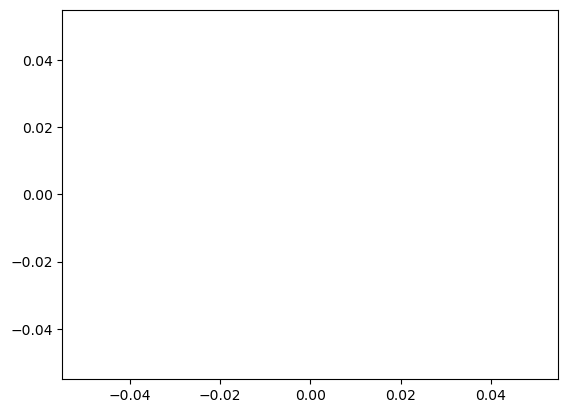

In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

fig, ax = plt.subplots()
line, = ax.plot([], [])

def init():
    line.set_data([], [])
    return line,

# 生成器函数控制帧数
def update(frame):
    x = np.linspace(0, 2*np.pi, 1000)
    y = np.sin(x + 0.1 * frame)
    line.set_data(x, y)
    return line,

# 使用切片来选择帧数范围（从第50到第100帧）
ani = FuncAnimation(fig, update, frames=range(50, 101), init_func=init, blit=True)
ani.save('haha.gif',fps=30)
